In [32]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import math

df = pd.read_csv('../data/budget-data-extracted.csv')
df.shape

(6776, 13)

In [13]:
df.isna().sum()

company_name            0
quote_id                0
description             0
qty                    92
unit_price            315
filter_efficiency     228
dimensions             83
item_type             993
Length                245
Height                245
Gutter                245
Depth                5007
Pockets              5007
dtype: int64

In [14]:
cols_to_clean = ['qty','unit_price', 'filter_efficiency','Length','Height','Gutter']
df_clean = df.dropna(subset=cols_to_clean)
df_clean = df_clean.drop(['Depth','Pockets','description','item_type'], axis=1)

In [15]:
filterTypes = ["G1","G2","G3","G4","M5","M6","F7","F8","F9","H13","H14"]

def getFilterType(x):
    for filterType in filterTypes:
        if filterType in x:
            return filterType
    return np.nan

df_model = df_clean.copy()
df_model['filter_efficiency'] = df_model['filter_efficiency'].apply(lambda x: getFilterType(x))
df_model = df_model.dropna(subset=['filter_efficiency'])

category_dummies = pd.get_dummies(df_model['filter_efficiency'], prefix='')
df_model.drop(['filter_efficiency','dimensions'], axis=1, inplace=True)

df_model = pd.concat([df_model, category_dummies], axis=1)
df_model.head()

,company_name,quote_id,qty,unit_price,Length,Height,Gutter,_F7,_F8,_F9,_G2,_G3,_G4,_H13,_H14,_M5,_M6
0,A Preditiva,17171.0,36.0,7.5,625.0,500.0,50.0,0,0,0,0,0,1,0,0,0,0
1,A Preditiva,17171.0,36.0,27.5,625.0,500.0,50.0,1,0,0,0,0,0,0,0,0,0
2,A Preditiva,17175.0,16.0,28.5,592.0,490.0,48.0,1,0,0,0,0,0,0,0,0,0
3,A Preditiva,18643.0,9.0,27.5,592.0,592.0,45.0,1,0,0,0,0,0,0,0,0,0
4,A Preditiva,18643.0,3.0,17.5,287.0,592.0,45.0,1,0,0,0,0,0,0,0,0,0


### Df without Company Name and QuoteId

In [16]:
df_no_CnQ = df_model.drop(['company_name', 'quote_id'], axis=1)
df_no_CnQ.to_csv('../data/training-CSVs/budget-data-model-no-company-quoteid.csv', index=False)
df_no_CnQ.head()

,qty,unit_price,Length,Height,Gutter,_F7,_F8,_F9,_G2,_G3,_G4,_H13,_H14,_M5,_M6
0,36.0,7.5,625.0,500.0,50.0,0,0,0,0,0,1,0,0,0,0
1,36.0,27.5,625.0,500.0,50.0,1,0,0,0,0,0,0,0,0,0
2,16.0,28.5,592.0,490.0,48.0,1,0,0,0,0,0,0,0,0,0
3,9.0,27.5,592.0,592.0,45.0,1,0,0,0,0,0,0,0,0,0
4,3.0,17.5,287.0,592.0,45.0,1,0,0,0,0,0,0,0,0,0


### Df using basic vocabulary for Company name and quoteId stays the same

In [17]:
#Find individual names
names = df_model['company_name'].unique()
proccessed_names = set()
for name in names:
    proccessed_names.add(re.sub(r'[^a-zA-Z]', '', str(name).lower()))

map_names = {}
for i, name in enumerate(proccessed_names):
    map_names[name] = i

df_Vocab = df_model.copy()
df_Vocab['company_name'] = df_Vocab['company_name'].apply(lambda x: map_names.get(re.sub(r'[^a-zA-Z]', '', str(x).lower())))
df_no_CnQ.to_csv('../data/training-CSVs/budget-data-model-Vocab.csv', index=False)
df_Vocab.head()

,company_name,quote_id,qty,unit_price,Length,Height,Gutter,_F7,_F8,_F9,_G2,_G3,_G4,_H13,_H14,_M5,_M6
0,118,17171.0,36.0,7.5,625.0,500.0,50.0,0,0,0,0,0,1,0,0,0,0
1,118,17171.0,36.0,27.5,625.0,500.0,50.0,1,0,0,0,0,0,0,0,0,0
2,118,17175.0,16.0,28.5,592.0,490.0,48.0,1,0,0,0,0,0,0,0,0,0
3,118,18643.0,9.0,27.5,592.0,592.0,45.0,1,0,0,0,0,0,0,0,0,0
4,118,18643.0,3.0,17.5,287.0,592.0,45.0,1,0,0,0,0,0,0,0,0,0


### One Hot Encoding Both the quote_id and the Company_Name

In [18]:
df_OneHot = df_model.copy()

#Apply a regex to format all company names
df_OneHot['company_name'] = df_OneHot['company_name'].apply(lambda x:re.sub(r'[^a-zA-Z]', '', str(x).lower()))

cols_to_encode = ['company_name', 'quote_id']

data_to_encode = df_OneHot[cols_to_encode]

encoder = OneHotEncoder(sparse=False, drop='first')
encoder.fit(data_to_encode)

encoded_data = encoder.transform(data_to_encode)
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cols_to_encode))

df_OneHot = pd.concat([df_OneHot.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
df_OneHot = df_OneHot.drop(cols_to_encode, axis=1)

df_OneHot.to_csv('../data/training-CSVs/budget-data-model-OneHot.csv', index=False)
df_OneHot.head()


,qty,unit_price,Length,Height,Gutter,_F7,_F8,_F9,_G2,_G3,...,quote_id_211130.0,quote_id_220207.0,quote_id_220315.0,quote_id_220428.0,quote_id_220513.0,quote_id_220620.0,quote_id_230912.0,quote_id_2207061721.0,quote_id_2207221707.0,quote_id_2207291200.0
0,36.0,7.5,625.0,500.0,50.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36.0,27.5,625.0,500.0,50.0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16.0,28.5,592.0,490.0,48.0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.0,27.5,592.0,592.0,45.0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,17.5,287.0,592.0,45.0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Handling company id and quote id
The way to handle the company_name and the quote_id lead to debate so we trained the models using three different dataframes, one with the company_name represented by an index from a vocabulary of the company names and the quote_id as is, one hot enconding both the the company_name and the quote_id and the last by dropping both collumns. However using one hot encoding increases the number of collumns from 17 to 120 which makes trainning the models too time consuming so we ended up only using it for the Neural Net Regression.

# Linear Regression

In [29]:
def get_metrics_lr(df, filter, scoring_metric, df_name):

    X_train, X_test, y_train, y_test = train_test_split(df.drop(['unit_price'], axis=1), df['unit_price'], test_size=0.2, random_state=42)
    # define param grid for grid search for linear regression model
    fit_interc = [True, False]
    posit_ = [True, False]
    parameters = dict(fit_intercept=fit_interc,positive=posit_)
    grid = GridSearchCV(estimator=LinearRegression(),
            param_grid=parameters,
            cv=5,
            scoring=scoring_metric)

    grid.fit(X_train, y_train)

    best_params = grid.best_params_

    y_pred = grid.predict(X_test)

    return {
        'df_name': df_name,
        'scoring_metric': scoring_metric,
        'filter': filter,
        'r2': r2_score(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': math.sqrt(mean_squared_error(y_test, y_pred)),
        'percentError': np.mean(np.abs((y_test - y_pred) / y_test)) * 100,
        'best_params': best_params
    }

# Space Vector Regression

In [30]:
def get_metrics_svr(df, filter, scoring_metric, df_name):

    X_train, X_test, y_train, y_test = train_test_split(df.drop(['unit_price'], axis=1), df['unit_price'], test_size=0.2, random_state=42)
    # define param grid for grid search for svr model
    c_param = [50, 75, 100, 125, 200, 250]
    kernel = ['rbf','poly']
    parameters = dict(C=c_param,kernel=kernel)
    grid = GridSearchCV(estimator=SVR(),
            param_grid=parameters,
            cv=5,
            scoring=scoring_metric)

    grid.fit(X_train, y_train)

    best_params = grid.best_params_

    y_pred = grid.predict(X_test)

    return {
        'df_name': df_name,
        'scoring_metric': scoring_metric,
        'filter': filter,
        'r2': r2_score(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': math.sqrt(mean_squared_error(y_test, y_pred)),
        'percentError': np.mean(np.abs((y_test - y_pred) / y_test)) * 100,
        'best_params': best_params
    }


# K Neighbors Regressor

In [21]:

def get_metrics_KNR(df, filter, scoring_metric, df_name):

    x_train, x_test, y_train, y_test = train_test_split(df.drop(['unit_price'], axis=1), df['unit_price'], test_size=0.2, random_state=42)
    grid = GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 5, 7, 10, 15, 17, 20],
                         'weights': ('uniform', 'distance'),
                         'p': [1, 2, 3]},
            cv=5,
            scoring=scoring_metric)

    grid.fit(x_train, y_train)

    best_params = grid.best_params_

    y_pred = grid.predict(x_test)

    return {
        'df_name': df_name,
        'scoring_metric': scoring_metric,
        'filter': filter,
        'r2': r2_score(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': math.sqrt(mean_squared_error(y_test, y_pred)),
        'percentError': np.mean(np.abs((y_test - y_pred) / y_test)) * 100,
        'best_params': best_params
    }

# Decision Tree

In [22]:

def get_metrics_DTR(df1, filter, scoring_metric, df_name):

    x_train, x_test, y_train, y_test = train_test_split(df1.drop(['unit_price'], axis=1), df1['unit_price'], test_size=0.2, random_state=42)
    grid = GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ('squared_error', 'friedman_mse', 'absolute_error', 'poisson'),
                         'splitter': ('best', 'random'),
                         'max_features': ('auto', 'sqrt', 'log2')},
            cv=5,
            scoring=scoring_metric)

    grid.fit(x_train, y_train)

    y_pred = grid.predict(x_test)

    best_params = grid.best_params_

    return {
        'df_name': df_name,
        'scoring_metric': scoring_metric,	
        'filter': filter,
        'r2': r2_score(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': math.sqrt(mean_squared_error(y_test, y_pred)),
        'percentError': np.mean(np.abs((y_test - y_pred) / y_test)) * 100,
        'best_params': best_params
    }

# Random Forest

In [23]:

def get_metrics_RFR(df1, filter, scoring_metric, df_name):

    x_train, x_test, y_train, y_test = train_test_split(df1.drop(['unit_price'], axis=1), df1['unit_price'], test_size=0.2, random_state=42)
    grid = GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [10, 50, 100],
                         'criterion': ('squared_error', 'absolute_error'),
                         'min_samples_split': [1,2, 3],
                         'max_features': ( 'sqrt', 'log2')},
            cv=5,
            scoring=scoring_metric)

    grid.fit(x_train, y_train)

    y_pred = grid.predict(x_test)

    best_params = grid.best_params_

    return {
        'df_name': df_name,
        'scoring_metric': scoring_metric,	
        'filter': filter,
        'r2': r2_score(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': math.sqrt(mean_squared_error(y_test, y_pred)),
        'percentError': np.mean(np.abs((y_test - y_pred) / y_test)) * 100,
        'best_params': best_params
    }


# Neural Network Regression

In [38]:
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import os

In [71]:
def get_best_weights(name):
    print(name)
    directory_path = '../weights/'+name+'/'

    file_names = os.listdir(directory_path)

    best_weights = file_names[len(file_names)-1]
    return best_weights

In [40]:
def scale_datasets(x_train, x_test):
  standard_scaler = StandardScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled

In [73]:
def get_metrics_NNR(df, filter, scoring_metric, df_name):  
    checkpoint_name = '../weights/'+filter+'/Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
    callbacks_list = [checkpoint]

    x_train, x_test, y_train, y_test = train_test_split(df.drop(['unit_price'], axis=1), df['unit_price'], test_size=0.2, random_state=42)
    x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)

    # Creating model using the Sequential in tensorflow
    model = Sequential()

    # The Input Layer :
    model.add(Dense(128, kernel_initializer='normal',input_dim = x_train_scaled.shape[1], activation='relu'))

    # The Hidden Layers :
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    model.add(Dense(256, kernel_initializer='normal',activation='relu'))

    # The Output Layer :
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    # build the model
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

    # train the model
    if( filter != 'geral'):
        model.fit(
            x_train_scaled.values, 
            y_train.values, 
            epochs=500, 
            batch_size=32,
            validation_split=0.2, callbacks=callbacks_list
        )
        

    weights_file = get_best_weights(filter) # choose the best checkpoint 
    model.load_weights('../weights/'+filter+'/'+weights_file) # load it
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

    y_pred = model.predict(x_test_scaled.values)

    return {
        'df_name': df_name,
        'scoring_metric': 'mean_absolute_error',	
        'filter': filter,
        'r2': r2_score(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': math.sqrt(mean_squared_error(y_test, y_pred)),
        'percentError': np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100
    }

# Results

This function recieves the get_Metrics function from one of the models and runs it for each of the dfs mentioned above, and for each of the metrics in the list

In [44]:
def results_all_paramenters( getMetrics):
    df_no_CnQ = pd.read_csv('../data/training-CSVs/budget-data-model-no-company-quoteid.csv')
    df_Vocab = pd.read_csv('../data/training-CSVs/budget-data-model-Vocab.csv')

    metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"]

    values = []
    for df in [(df_no_CnQ, "no_CnQ"), (df_Vocab, "Vocab")]:
        df_geral = df[0]
        df_G4 = df_geral[df_geral['_G4'] == 1]
        df_F7 = df_geral[df_geral['_F7'] == 1]
        df_M5 = df_geral[df_geral['_M5'] == 1]
        for metric in metrics:
            for model in [(df_geral, "geral"), (df_G4, "G4"), (df_F7, "F7"), (df_M5, "M5")]:
                values.append(getMetrics(model[0], model[1], metric, df[1]))

    return values

In [74]:
results = results_all_paramenters(get_metrics_NNR)
df_results = pd.DataFrame(results)
df_results.to_csv('../results/' + "NNR" + '.csv', index=False)

geral
38/38 [==============================] - 0s 3ms/step
Epoch 1/500
61/61 [==============================] - ETA: 0s - loss: 4.5394 - mean_absolute_error: 4.5394
Epoch 1: val_loss improved from inf to 2.63046, saving model to ../weights/G4\Weights-001--2.63046.hdf5
61/61 [==============================] - 2s 13ms/step - loss: 4.5394 - mean_absolute_error: 4.5394 - val_loss: 2.6305 - val_mean_absolute_error: 2.6305
Epoch 2/500
59/61 [============================>.] - ETA: 0s - loss: 2.0479 - mean_absolute_error: 2.0479
Epoch 2: val_loss improved from 2.63046 to 2.43922, saving model to ../weights/G4\Weights-002--2.43922.hdf5
61/61 [==============================] - 0s 7ms/step - loss: 2.0431 - mean_absolute_error: 2.0431 - val_loss: 2.4392 - val_mean_absolute_error: 2.4392
Epoch 3/500
55/61 [==========================>...] - ETA: 0s - loss: 1.9608 - mean_absolute_error: 1.9608
Epoch 3: val_loss improved from 2.43922 to 2.38026, saving model to ../weights/G4\Weights-003--2.38026.hdf5


In [33]:
models =  [(get_metrics_DTR,"DTR"),(get_metrics_KNR, "KNR"),(get_metrics_RFR, "RFR"),(get_metrics_svr, "SVR"), (get_metrics_lr, "LR"), (get_metrics_NNR, "NNR")]
for model in models:
    results = results_all_paramenters(model[0])
    df_results = pd.DataFrame(results)
    df_results.to_csv('../results/' + model[1] + '.csv', index=False)

SVR
no_CnQ
r2
neg_mean_squared_error
neg_mean_absolute_error
Vocab
r2
neg_mean_squared_error
neg_mean_absolute_error
LR
no_CnQ
r2
neg_mean_squared_error
neg_mean_absolute_error
Vocab
r2
neg_mean_squared_error
neg_mean_absolute_error


In [36]:
df_DTR = pd.read_csv('../results/DTR.csv')
df_KNR = pd.read_csv('../results/KNR.csv')
df_RFR = pd.read_csv('../results/RFR.csv')
df_SVR = pd.read_csv('../results/SVR.csv')
df_LR = pd.read_csv('../results/LR.csv')
df_NNR = pd.read_csv('../results/NNR.csv')

names = ['Decision Tree Regressor', 'K Neighbors Regressor', 'Random Forest Regressor', 'Support Vector Regressor', 'Linear Regressor', 'Neural Network Regressor']

allResults = pd.DataFrame()
for i, df in enumerate([df_DTR, df_KNR, df_RFR, df_SVR, df_LR, df_NNR]):
    df.insert(0, 'Model', names[i])
    allResults = pd.concat([allResults, df], ignore_index=True)

allResults.to_csv('../results/allResults.csv', index=False)

# Best models
- Filter F7 decision tree scoring metric r2
- Filter G4 random Forest neg_root_mean_squared_error
- Filter M5 RandomForest	neg_mean_absolute_error	
- Geral decisionTree	neg_mean_squared_error

# Visualizations

In [ ]:
def plot_difference(y_test, y_pred):
    sorted_indices = np.argsort(y_test)

    # Apply sorting to both arrays using the sorted indices
    sorted_y_test = y_test.values[sorted_indices]
    sorted_y_pred = y_pred[sorted_indices]

    plt.figure(figsize=(50,15))
    plt.plot(sorted_y_test, label='Real')
    plt.plot(sorted_y_pred, label='Predicted')
    plt.legend()
    plt.show()

# G4 RandomForestRegressor Plots

c:\SittySoftware\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\SittySoftware\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\SittySoftware\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\SittySoftware\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\SittySoftware\anaconda3\lib\site-

0.5097940199638549
8.757253831937087
1.3802579470198675
2.959265758923501


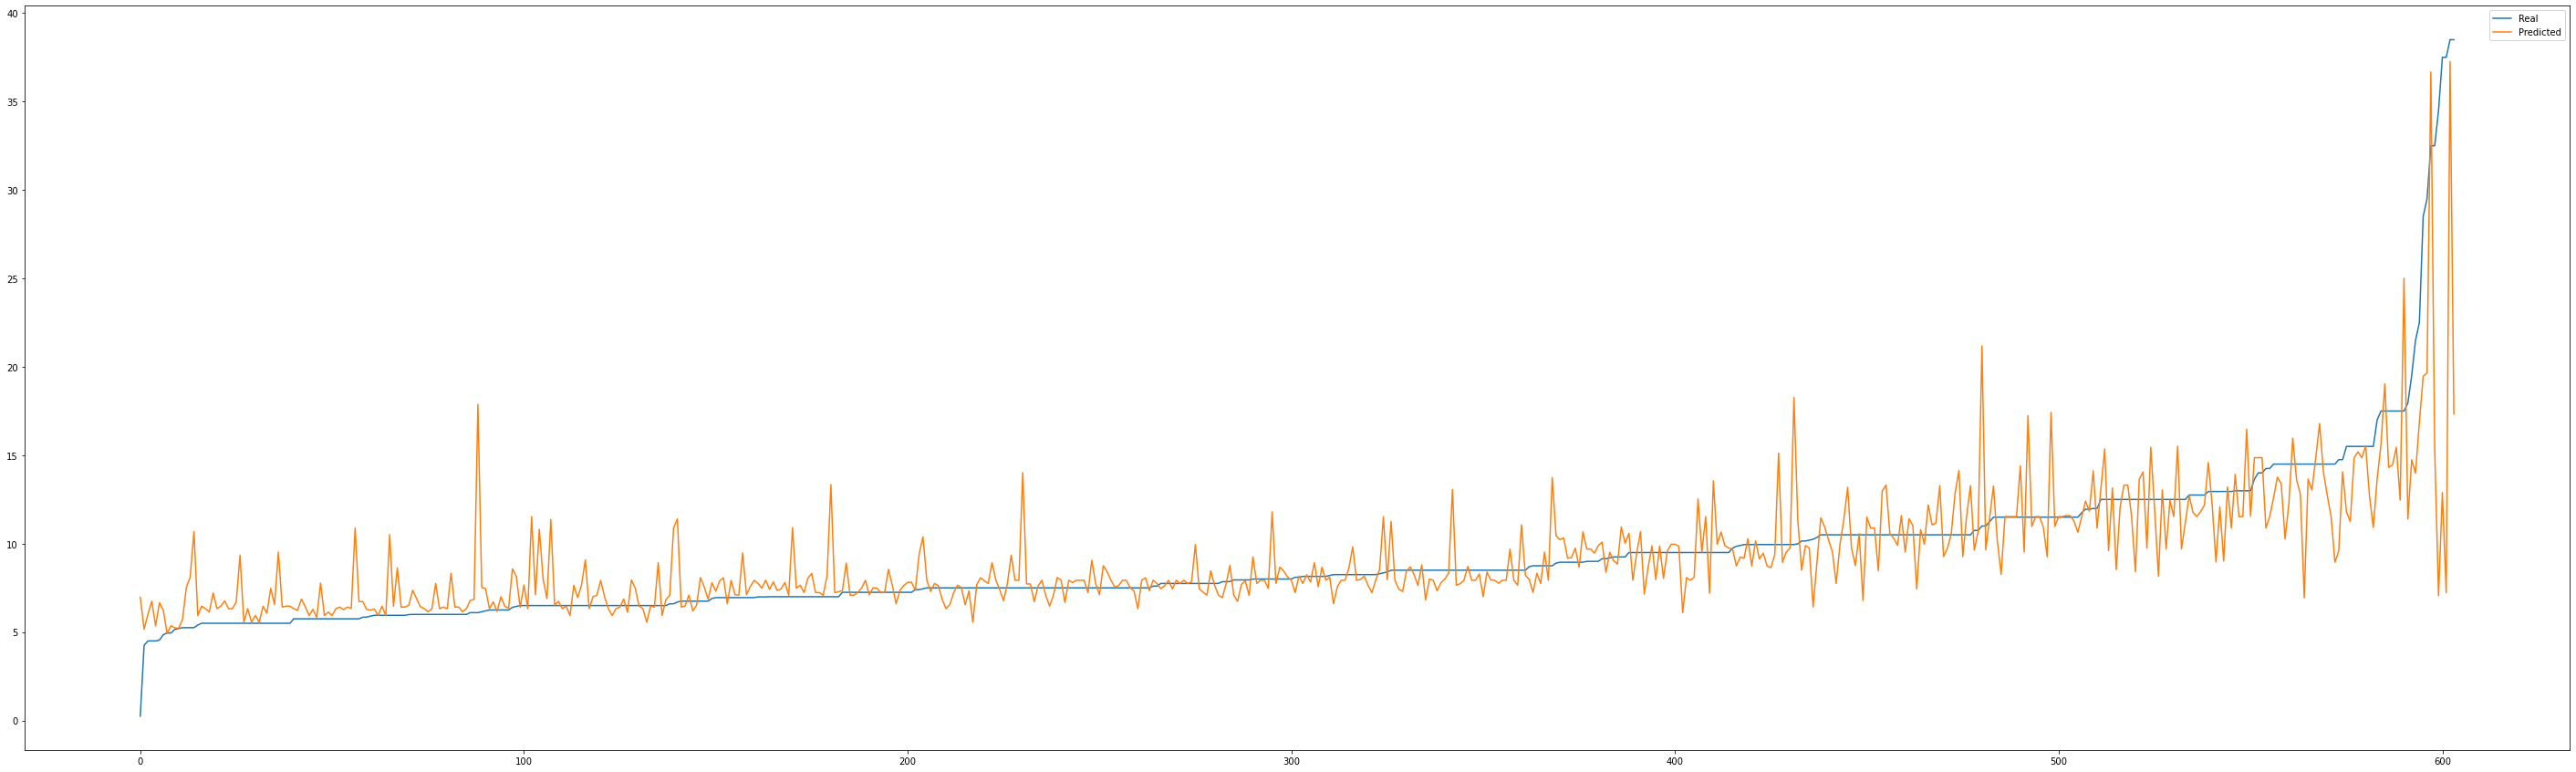

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

x_train, x_test, y_train, y_test = train_test_split(df_G4.drop(['unit_price'], axis=1), df_G4['unit_price'], test_size=0.2, random_state=42)
grid = GridSearchCV(estimator=RandomForestRegressor(),
            param_grid={'n_estimators': [10, 50, 100],
                        'criterion': ('squared_error', 'absolute_error'),
                        'min_samples_split': [1,2, 3],
                        'max_features': ( 'sqrt', 'log2')},
        cv=5,
        scoring='neg_root_mean_squared_error')

grid.fit(x_train, y_train)
y_pred = grid.predict(x_test)

print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

plot_difference(y_test, y_pred)

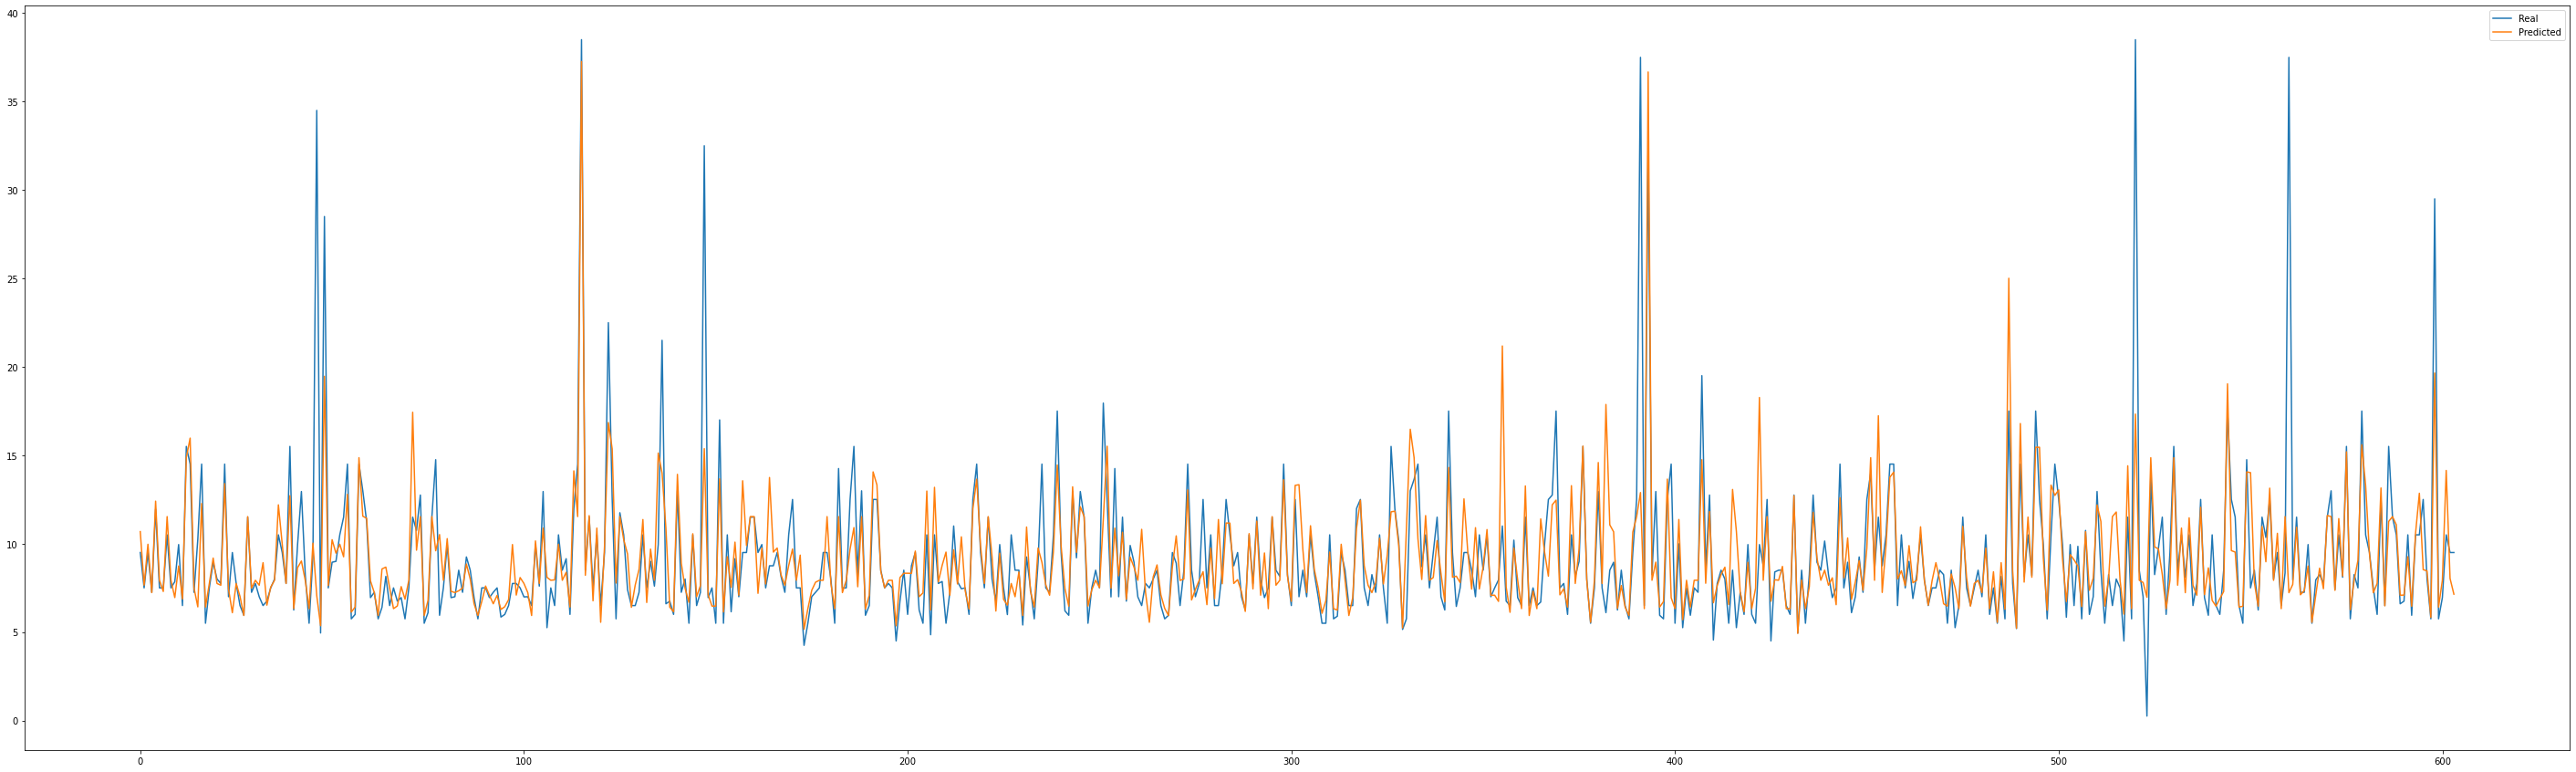

In [ ]:
plt.figure(figsize=(50,15))
plt.plot(y_test.values, label='Real')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# F7 DecisionTreeRegressor Plots

0.8637545769291701
28.642997654052387
2.943507223027624
5.351915325755106


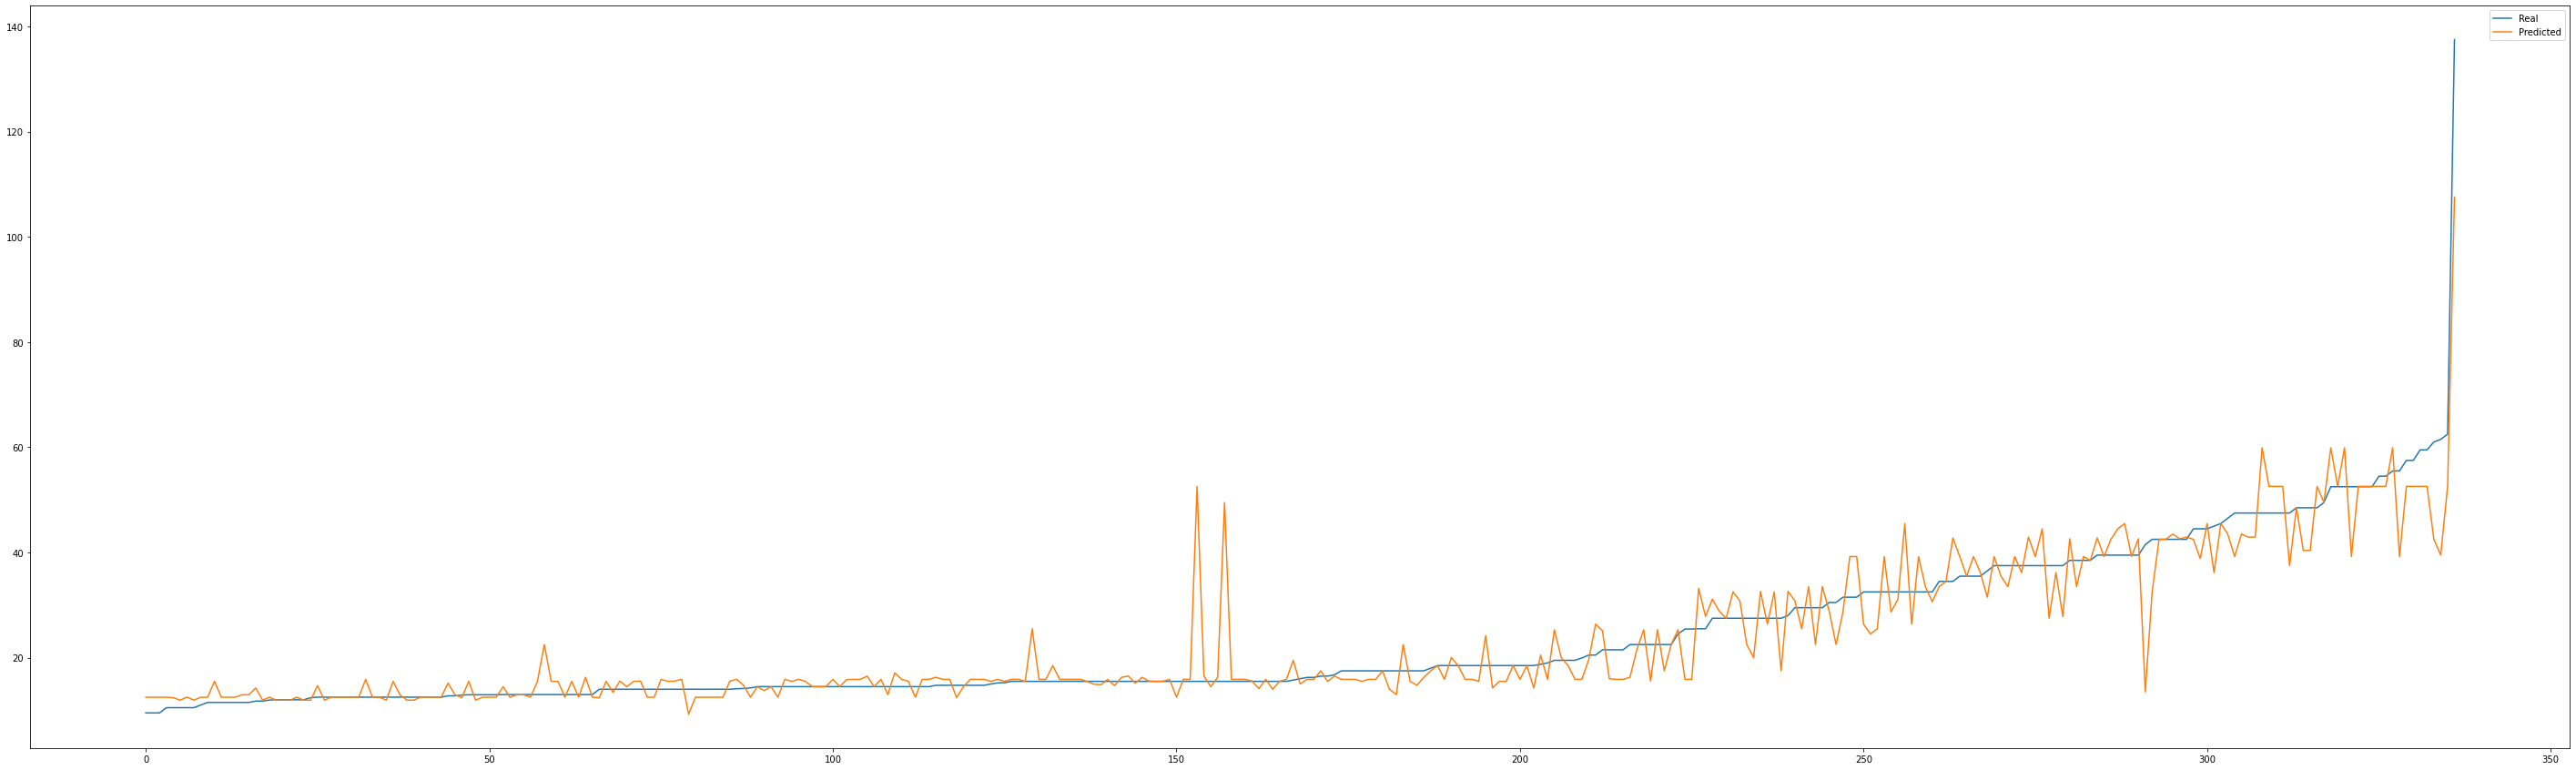

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

x_train, x_test, y_train, y_test = train_test_split(df_F7.drop(['unit_price'], axis=1), df_F7['unit_price'], test_size=0.2, random_state=42)
grid = GridSearchCV(estimator=DecisionTreeRegressor(),
            param_grid={'criterion': ('squared_error', 'friedman_mse', 'absolute_error', 'poisson'),
                        'splitter': ('best', 'random'),
                        'max_features': ('auto', 'sqrt', 'log2')},
        cv=5,
        scoring="r2")

grid.fit(x_train, y_train)

y_pred = grid.predict(x_test)

print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

plot_difference(y_test, y_pred)

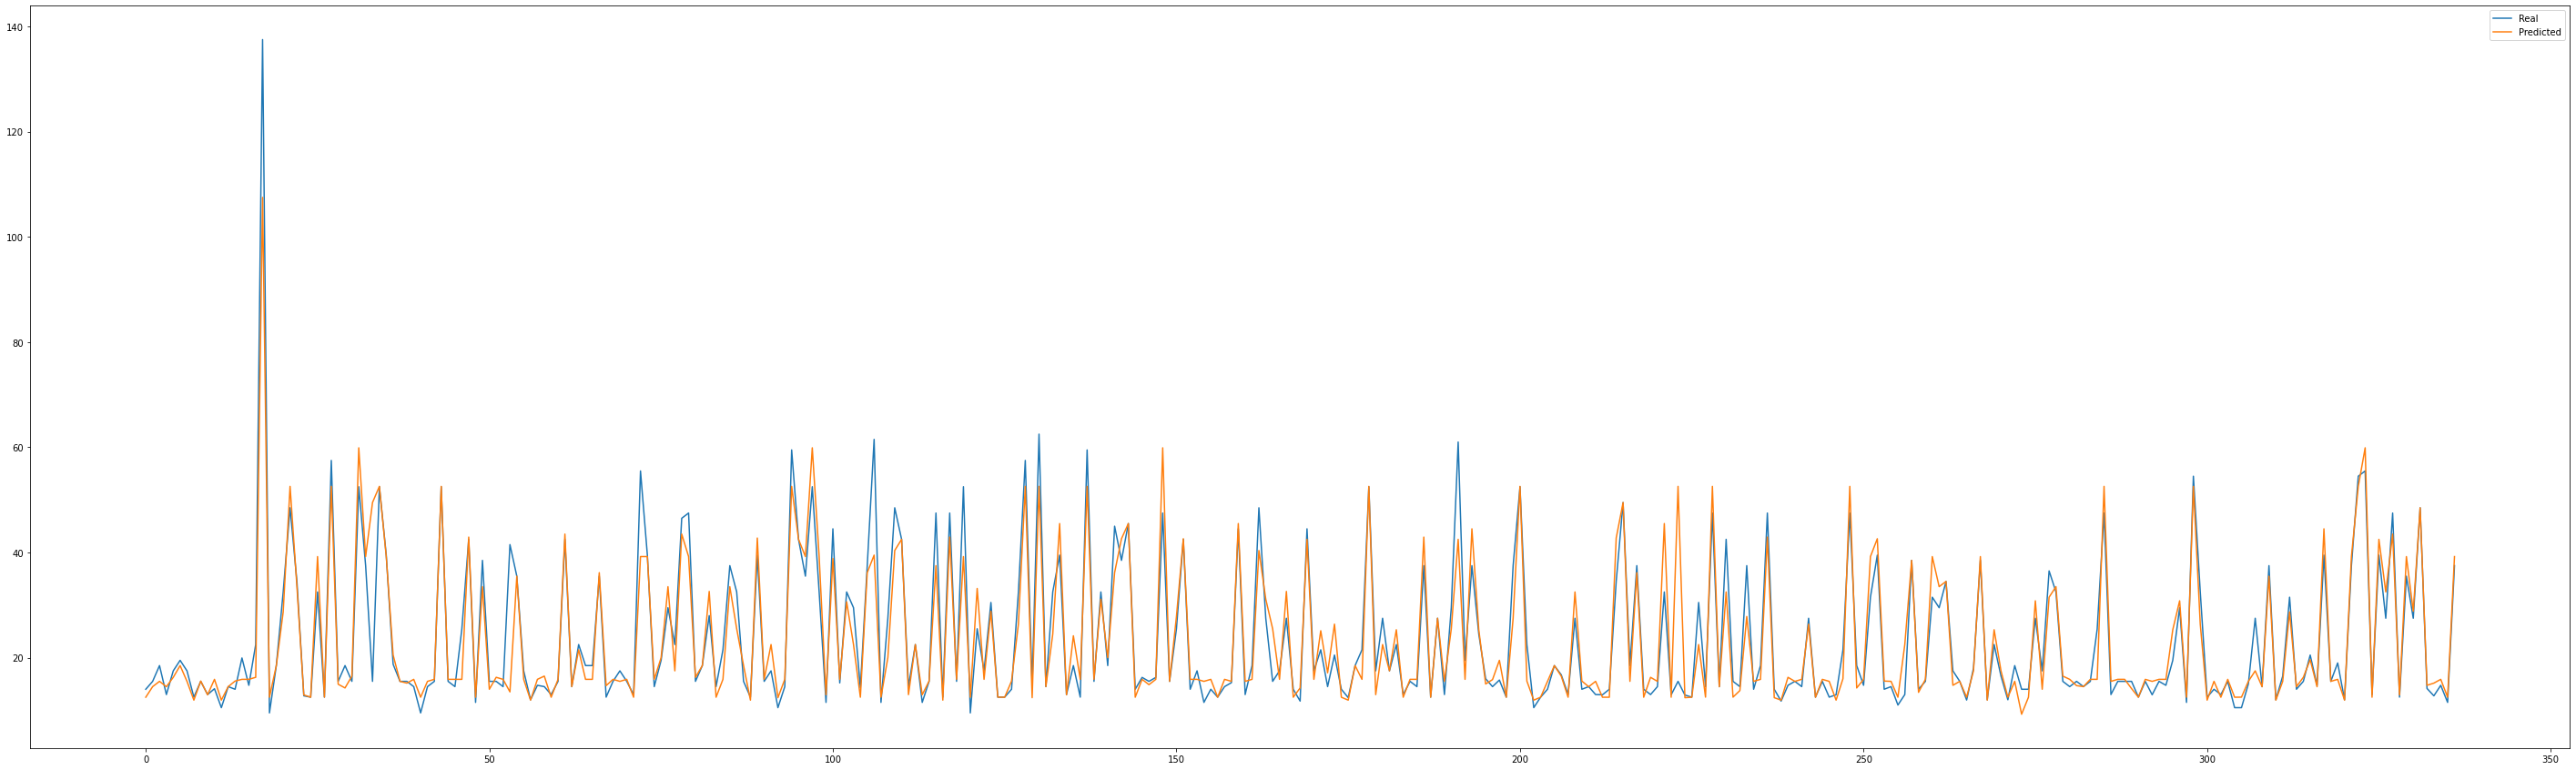

In [ ]:

plt.figure(figsize=(50,15))
plt.plot(y_test.values, label='Real')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# M5 RandomForestRegressor Plots

c:\SittySoftware\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\SittySoftware\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\SittySoftware\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\SittySoftware\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\SittySoftware\anaconda3\lib\site-

0.5247914621524232
8.489332971270697
1.3655649834437085
2.9136459927847613


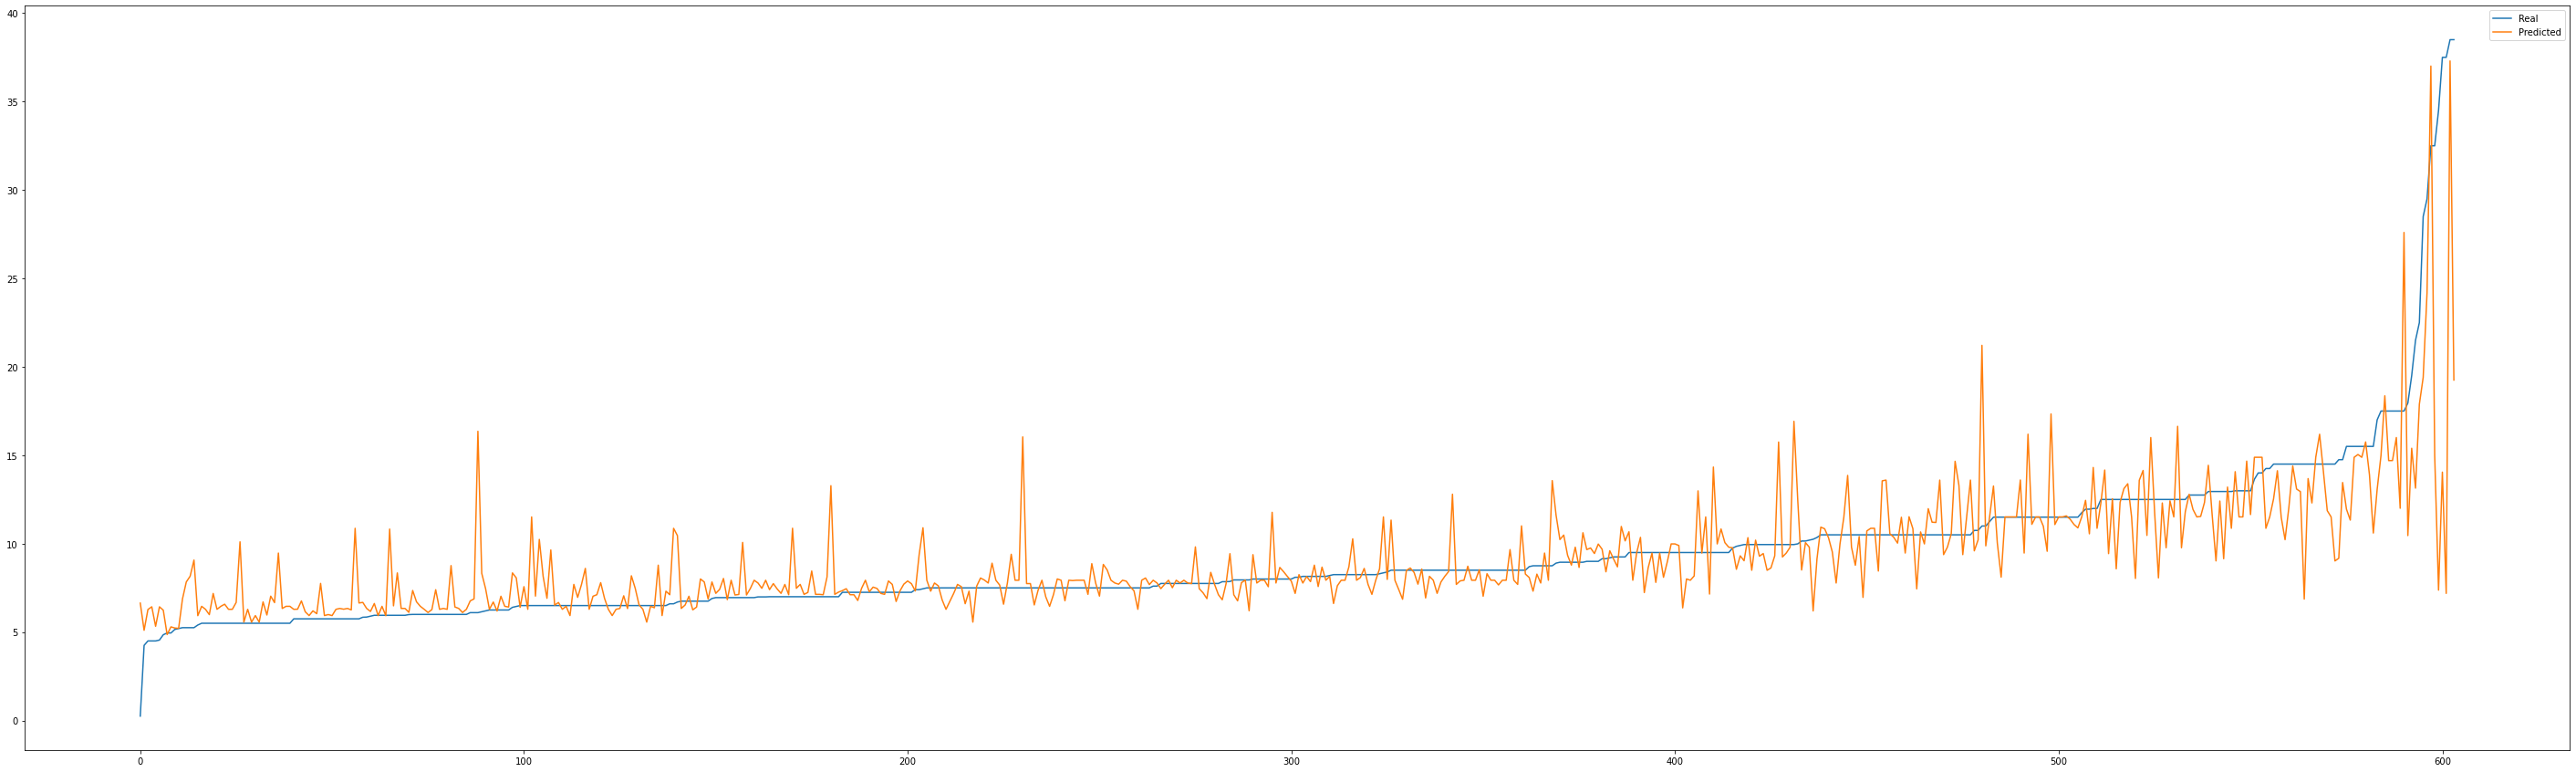

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

x_train, x_test, y_train, y_test = train_test_split(df_G4.drop(['unit_price'], axis=1), df_G4['unit_price'], test_size=0.2, random_state=42)
grid = GridSearchCV(estimator=RandomForestRegressor(),
            param_grid={'n_estimators': [10, 50, 100],
                        'criterion': ('squared_error', 'absolute_error'),
                        'min_samples_split': [1,2, 3],
                        'max_features': ( 'sqrt', 'log2')},
        cv=5,
        scoring='neg_mean_absolute_error')

grid.fit(x_train, y_train)
y_pred = grid.predict(x_test)

print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

plot_difference(y_test, y_pred)

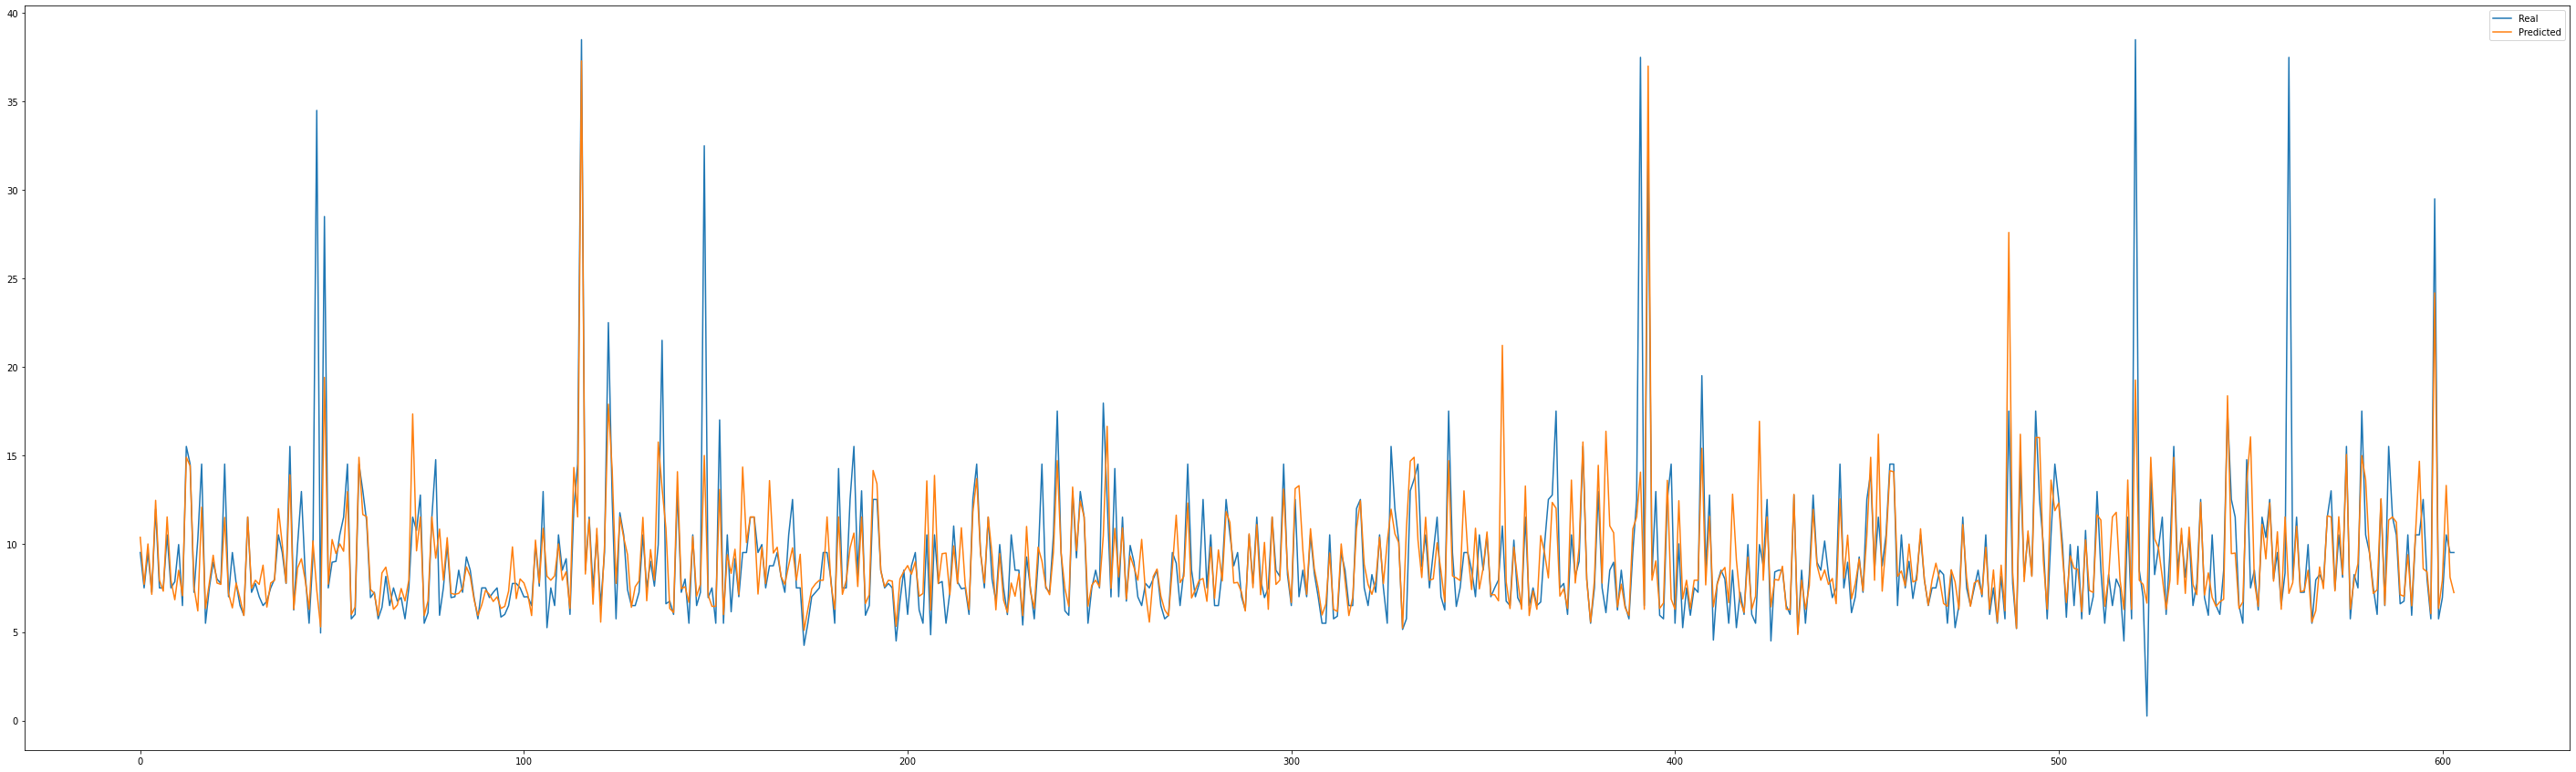

In [ ]:
plt.figure(figsize=(50,15))
plt.plot(y_test.values, label='Real')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# Geral RandomTreeRegressor Plots

0.8804669995145897
25.129530044510386
2.7325964391691397
5.012936269743551


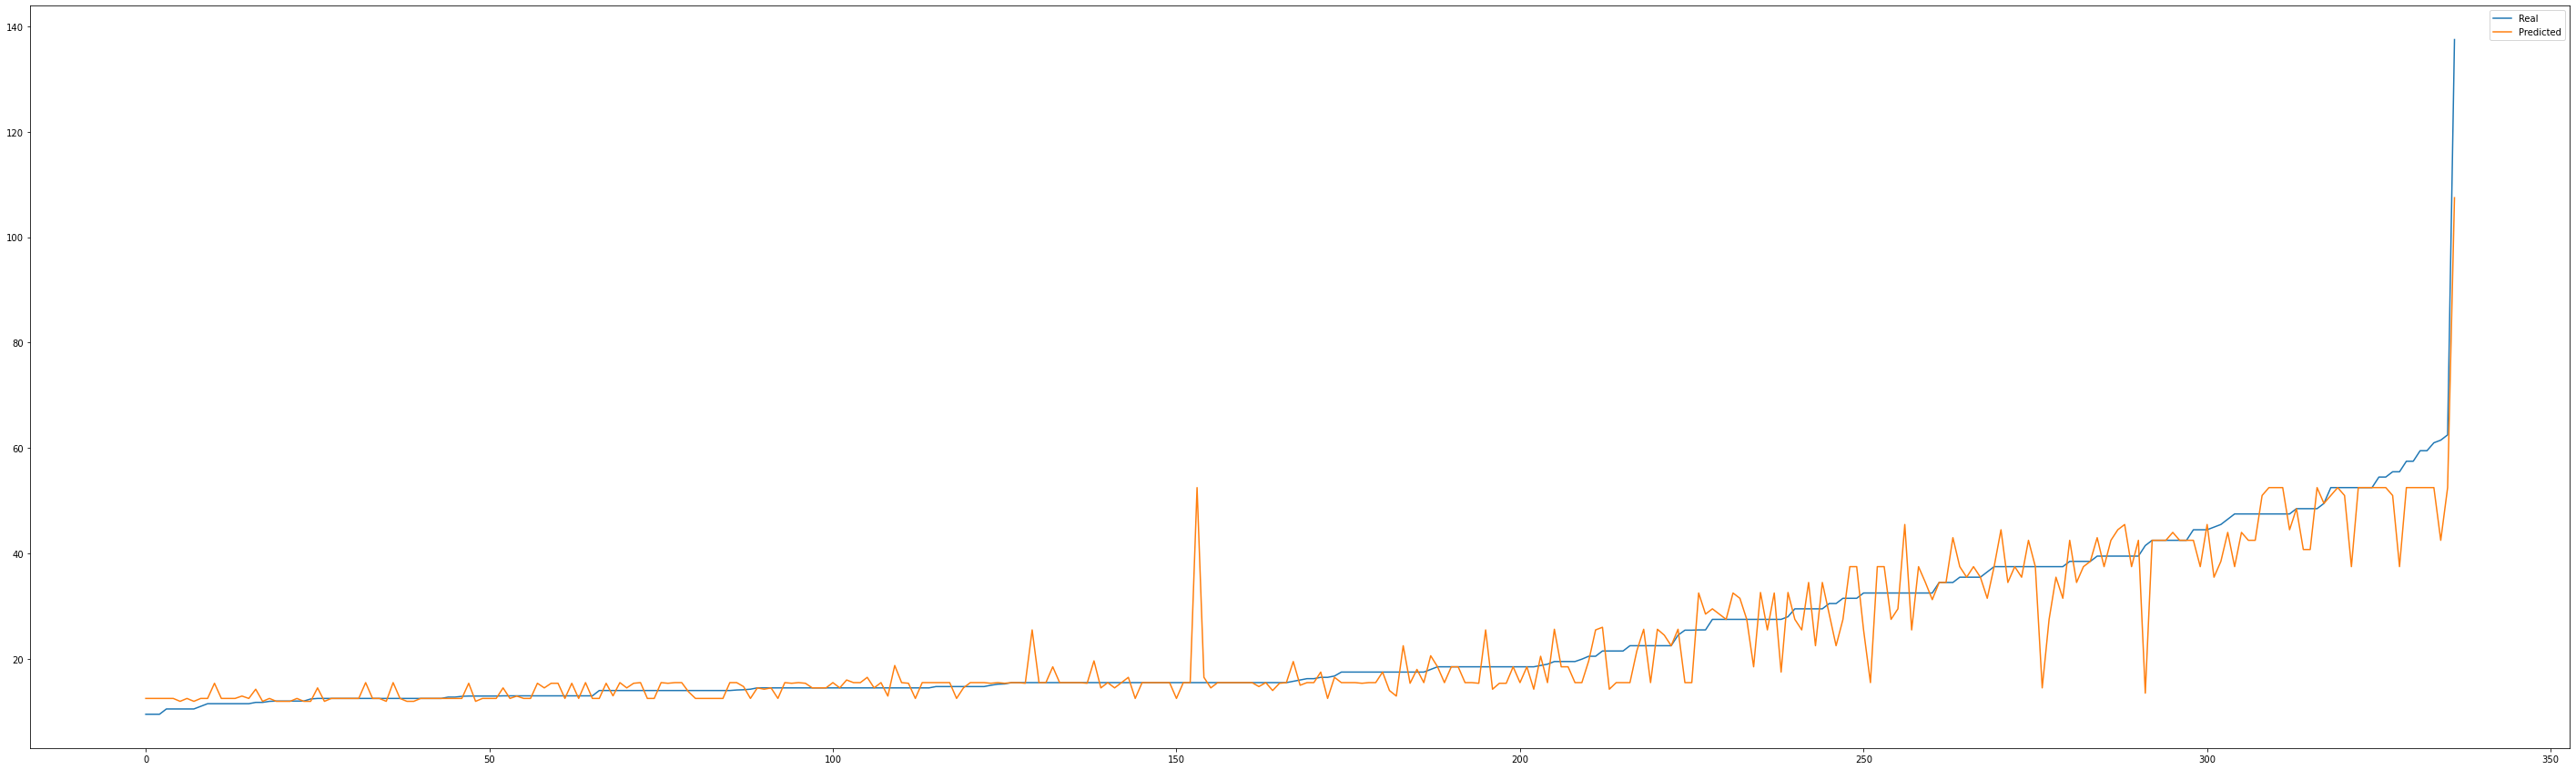

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

x_train, x_test, y_train, y_test = train_test_split(df_F7.drop(['unit_price'], axis=1), df_F7['unit_price'], test_size=0.2, random_state=42)
grid = GridSearchCV(estimator=DecisionTreeRegressor(),
            param_grid={'criterion': ('squared_error', 'friedman_mse', 'absolute_error', 'poisson'),
                        'splitter': ('best', 'random'),
                        'max_features': ('auto', 'sqrt', 'log2')},
        cv=5,
        scoring="neg_mean_squared_error")

grid.fit(x_train, y_train)

y_pred = grid.predict(x_test)

print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

plot_difference(y_test, y_pred)


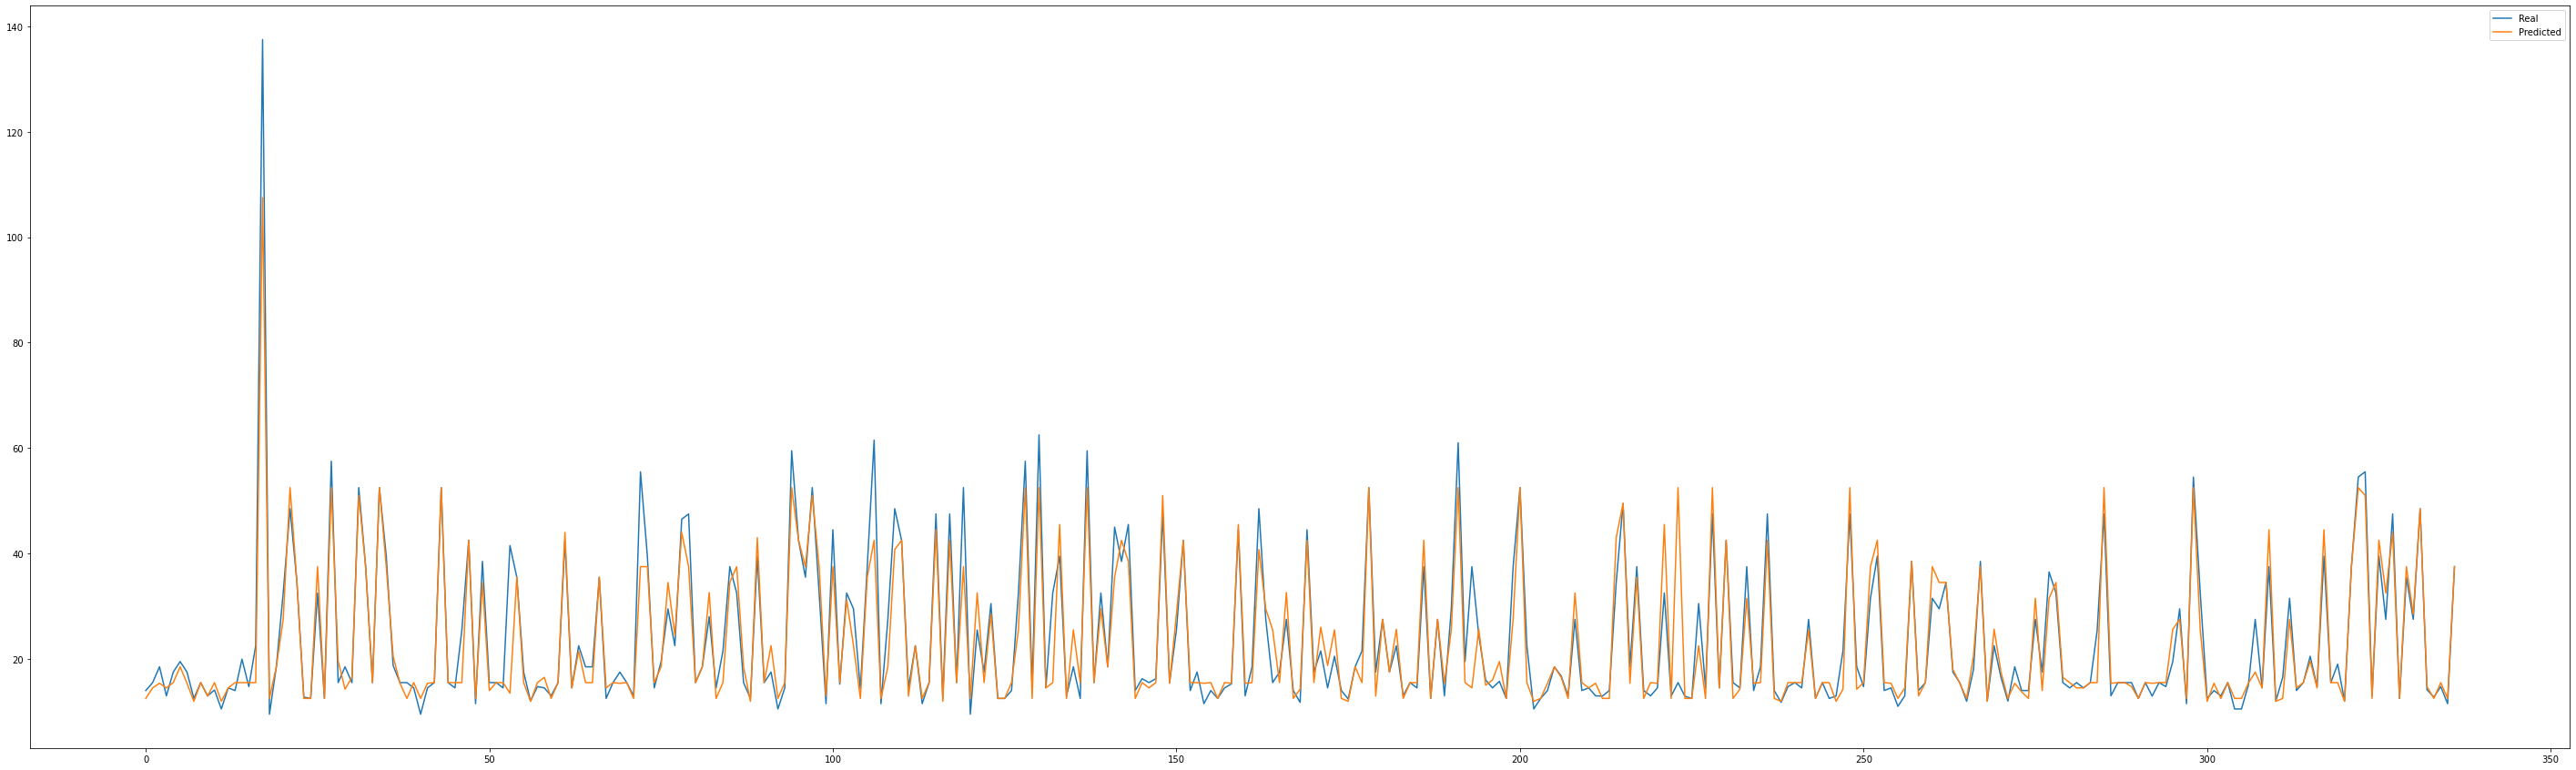

In [ ]:
plt.figure(figsize=(50,15))
plt.plot(y_test.values, label='Real')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()